# Tutorial on Levinthal (1997)

In this tutorial, you will be introduced to a simple model that replicates the main finding from the paper by Dan Levinthal, published in 1997 in Management Science. 

This tutorial provides a barebones description of the model. If you want to explore a more flexible version or explore how different agents or bandit distributions would affect Jerker's and Jim's results please Maciej Workiewicz's full code. There you will find code on how to replicate also other seminal papers on NK landscapes.  

**Reference:** Levinthal, D. A. (1997). Adaptation on rugged landscapes. Management science, 43(7), 934-950.

## NK Landscape
In Levinthal (1997) the agent is quite simple. The environment does have some intricancies. 

### 1. Create Dependencies
The k interdependencies in Levinthal's are created at random. Basically, one needs a matrix where the diagonal has 1s and the off-diagonals have a probabilty k/n of drawing a 1. A one represents an interdependency and a zero the lack of it.  
This function includes two variables N and K and outputs a NxN interdependency matrix. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_dependencies(n, k):
    prob = float(k)/(n-1)
    dep_mat = np.zeros((n,n)).astype(int)
    for i in range(n):
        for j in range(n):
            if i != j: dep_mat[i][j] = np.random.choice([1,0], p = [prob,1-prob])
            else: dep_mat[i][i] = 1
    return(dep_mat)

### Example: How to create a interdependency matrix
Below you see how an interdependency matrix is built. If you run the code again, the matrix will change. 

In [2]:
n = 4
k = 2
dep_mat = create_dependencies(n, k)

dep_mat

array([[1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 1]])

### 2. Fitness Contributions
The second step is building the fitness contributions for each item in the interdependency matrix.  

#### Example
For example let's imagine that our interdependency matrix is: 
   
|1 0 0 0|  
|0 1 1 0|  
|1 0 1 1|  
|1 1 1 1|  

What this means is that the fitness contributions of the first value of a policy P = [a,b,c,d] will depend ONLY on the value of the first policy value, namely whether a is 1 or 0. Formally the fitness contribution will have twwo values:  
* f1[0] = z0  
* F1[1] = z1  
Where z0 and z1 are numbers drawn from a uniform distribution. 
  
The second row is more complicated as there is one interdependency. Here we will have that the second and third policy values are needed to calculate the fitness contribution. For this we need a function with four values as there are four possible combinations of a and b. The functions have the form f2[b,a].  
* f2[00] = y0
* f2[01] = y1
* f2[10] = y2
* f2[11] = y3

The third row has 2 interdependencies. Now the fitness contributions depends on the values of a, c, and d. The fitness contribution has the for f3[c,d,a]. To depict it, we draw a truth table.   
  
c  d  a  |  f3  
0  0  0  |  x0  
0  0  1  |  x1  
0  1  0  |  x2  
0  1  1  |  x3  
1  0  0  |  x4  
1  0  1  |  x5  
1  1  0  |  x6  
1  1  1  |  x7  

Finally the last item dependes on so the fitness contribution will need 2^16 values to be created: f4[d,a,b,c].   

To create the fitness contributions we need a function that takes one interdependence matrix and outputs the fitness contributions functions for each position. That is, a function thatout puts the two f1, four f2, eight f3, and 16 f4 of the previous example. The function later on should have a structure such that if one tells it that a = 0 and b = 1 it can give f2[b,a] = y2. For this the ideal structure is a list of dictionaries. Each fitness contribution function is a dictionary that one gives the values and it outputs the  and the dictionaries are joined together in a list. Below you find a function that does just that.

#### Fitness contribution generator
The function first creates an empty list. This list will be filled with the dictionaries of fitness contribution functions.   
The next step is entering a for-loop over the N rows of the interdependency matrix. For each iteration in the for-loop, we create an empty dictionary and start a new for-loop. The second for-loop will go over 2^q iterations, where q is the number of 1's in the interdependency matrix (**note:** on average q = k+1 but not every time), On every iteration a new entry is created in the dictionary. The entry has the binary translation of the iteration as its key and a draw from a uniform distribution as its value. At the end the function output a list of with the dictionaries as its entry. 
You see the code below and the outputs is the list of dictionaries of the dependency matrix created in the prior section. 

In [3]:
def fitness(dep_mat):
    epis = []
    for i in range(len(dep_mat)): 
        epi_row = {}
        for j in range(2**sum(dep_mat[i])): epi_row[bin(j)] = np.random.random()
        epis.append(epi_row)
    return(epis)

fit_con = fitness(dep_mat)
fit_con

[{'0b0': 0.6535825650637801,
  '0b1': 0.7697011919400729,
  '0b10': 0.578460795955313,
  '0b11': 0.28057930602681336,
  '0b100': 0.7124993151769322,
  '0b101': 0.3793476822968129,
  '0b110': 0.33348429711071703,
  '0b111': 0.678392118783819},
 {'0b0': 0.9554598407524872,
  '0b1': 0.2864333469038465,
  '0b10': 0.017462696177842907,
  '0b11': 0.6122530765671762,
  '0b100': 0.13174545727494158,
  '0b101': 0.6599089502819071,
  '0b110': 0.28049970438062455,
  '0b111': 0.5509615822422482},
 {'0b0': 0.6980874961746276,
  '0b1': 0.37464908024509314,
  '0b10': 0.2505792335477638,
  '0b11': 0.8847466813002146,
  '0b100': 0.9057193506009633,
  '0b101': 0.8293390402127631,
  '0b110': 0.921701883783362,
  '0b111': 0.31832174498824073},
 {'0b0': 0.43549082698494146,
  '0b1': 0.5632623401123106,
  '0b10': 0.8838067985220653,
  '0b11': 0.29751525980515725,
  '0b100': 0.6034964757236799,
  '0b101': 0.360152142731639,
  '0b110': 0.9503397780923879,
  '0b111': 0.43168010233383003,
  '0b1000': 0.46492177

## 3. Calculate policy payoffs
The next step is to calculate the payoff of a policy based upon the fitness contribution functions. To do this we require two things. First to calculate the payoff contribution of every value in a policy and then sum all of them together. We start with the first task. 

### 3.1 Transform Row
Let's continue with the example. But now we have the polict P = [0101].  
In the case of the first value we know we should get z0 as fitness contribution. In the second row, y2 and so on. To do this we need to create a function that takes the values of the policy and matches them to the values other values that are interdependent with it.  
THe function below is given two inputs, a policy and a row of a dependency matrix.  It creates an empty list and starts to populate it. It does this by starting a for-loop for every element of the policy. If the item of that index is 1 in the interdependency row then it appends the value of policy to the list. If not, it continues to the next policy value. In this way, only the interdependent items are stored. With this, the programs has a list with items that are relevant to calculate the fitness contribution for this policy.     
For example, in the case from before we would have as an output of the for-loop [0] in the first row, [1,0] in the second row, [0,1,1] in the third row and [1,0,1,0] for the last row. This output is called interact_row
These values however are not understandable by the dictionaries of the fitness contribution. The last rows of the function translate the list into a binary value. So that later the dictonary can be queried.   
The process starts by starting trans_pol = 0. This value will store the key value for the dictionary. Then a for-loop starts. The for-loop has the range reversed so that the we keep the items to the left of the list being more significant. This is important because in the the next step we multiply the value of interact_row[i] with the 2^index value. By reversing the order we have that the item most to left in the list will be multiplied by 2^4 if we follow the example from before, the item next to it by 2^3 and so on. The product of the multiplications is added on every loop to the trans_pol value. At the end we have a decimal value. We transform the decimal value and the output is a key we can use in the dictionaries from the fitness contribution. For example for the first row from before we get '0b0', for the second '0b10', for the third '0b011' and for the last row, '0b1010'.  
Below you see an example of this function for the same policy we have used in this example but for the randomly generate dependency matrix from before. 

In [4]:
def transform_row(policy,dep_row):
    interact_row = []
    for i in range(len(policy)):
        if dep_row[i] == 1: interact_row.append(policy[i])
    trans_pol = 0
    for j in reversed(range(len(interact_row))): trans_pol += (2**j)*interact_row[j]
    return(bin(trans_pol))

transform_row([0,1,0,1], dep_mat[1])

'0b10'

### 3.2 Transform Matrix
The transform_row function is called by a transform_matrix function whose job is to take a policy and output a set of keys for the the list of fitness contributions. To do this basically what it does is to to call the transform_row N times can fill out a list with the output of each of the calls of the function. In the example from above we would have: ['0b0',  '0b10', '0b011', '0b1010'] as an output. Below you see an example of the function working.  

In [5]:
def transform_matrix(policy,dep_mat):
    int_mat = []
    for i in range(len(dep_mat)): int_mat.append(transform_row(policy,dep_mat[i]))
    return(int_mat)

transform_matrix([0,1,0,1],dep_mat)

['0b110', '0b10', '0b10', '0b1010']

### 3.3 Payoff
The payoff function has three inputs, the policy for which to calculate a payoff, the interdependency matrix, and the list of fitness contributions.  The first action it does it to transform the policy into keys to the fitness cotnribution dictionaries. After this is done it sums the entries of all the fitness contributions of the key values and divides the sum by the length of the policy. The last part is done to get a value between 0 and 1. Below we see and example of the code working. 

In [6]:
def payoff(policy,dep_mat,fit_con):
    pay = 0.0
    keys = transform_matrix(policy, dep_mat)
    for i in range(len(policy)): pay += fit_con[i][keys[i]]/len(policy)
    return(pay)

payoff([0,1,0,1],dep_mat,fit_con)

0.23903310305781653

## 4. Make full-landscape
Now that we can calculate the payoff for one policy we can make the full-landscape. However, to calculate the landscape we need to make a function that takes integers and makes policies.

### 4.1 Integer to List
This function takes two arguments first a number in integer and then the length of the desired list. This is important because when one transforms an integer to binary in Python, the output cuts the 0s to the left. So the policy length is altered. This function prevents that.  Below you can see an example.  

**Note:** In prior functions we had to translate policies from list to integer, this function does the opposite. If we used this functions only here, then it would be a waste. However, there are benefits to having policies as lists. Especially when regarding agents searching in the landscape.

In [7]:
def int2list(pol_int, n):
    pol_str = bin(pol_int)
    policy = [int(pol) for pol in pol_str[2:]]
    if len(policy) < n: policy = [0]*(n-len(policy))+policy
    return(policy)

int2list(5, 4)

[0, 1, 0, 1]

### 4.2 Calculate Landscape
Having the translating function, the function that calculates the landscape is just a for-loop that fills up a dictionary with the payoffs for each policy and then puts them together into one dataframe we can use later while searching.   
Below you can see an example of the full landscape. 

In [8]:
def calc_landscape(dep_mat, fit_con):
    lands = []
    n = dep_mat.shape[0]
    for i in range(2**n): 
        lands.append({'int_pol':i, 'policy': np.asarray(int2list(i,n)), 'payoff':payoff(int2list(i,n), dep_mat, fit_con)})
    return(pd.DataFrame(lands))
calc_landscape(dep_mat, fit_con)

,int_pol,payoff,policy
0,0,0.685655,"[0, 0, 0, 0]"
1,1,0.707742,"[0, 0, 0, 1]"
2,2,0.573636,"[0, 0, 1, 0]"
3,3,0.658322,"[0, 0, 1, 1]"
4,4,0.432577,"[0, 1, 0, 0]"
5,5,0.239033,"[0, 1, 0, 1]"
6,6,0.682751,"[0, 1, 1, 0]"
7,7,0.483099,"[0, 1, 1, 1]"
8,8,0.498511,"[1, 0, 0, 0]"
9,9,0.451651,"[1, 0, 0, 1]"


## Search in a Rugged Landscape
Below I introduce the code for searching in NK landscape, equivalent to the one from Levithnal (1997)
For this I create a agent class. The agent is very simple, it just knows the percentage of time it can make a long jump. 
Levinthal includes other aspects like myopia but this is not in the code at the moment. 

### Agent

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def transform_row(policy,dep_row):
    interact_row = [policy[i] for i in range(len(policy)) if dep_row[i] == 1]
    trans_pol = list2int(interact_row)
    return(bin(trans_pol))

def transform_matrix(policy,dep_mat):
    int_mat = [transform_row(policy,dep_mat[i]) for i in range(len(dep_mat))]
    return(int_mat)

def int2list(pol_int, n):
    pol_str = bin(pol_int)
    policy = [int(pol) for pol in pol_str[2:]]
    if len(policy) < n: policy = [0]*(n-len(policy))+policy
    return(policy)

def list2int(pol_list):
    pol_int = np.sum([(2**j)*pol_list[j] for j in reversed(range(len(pol_list)))])
    return(pol_int)

def find_neighbors(policy):
    neighbors = []
    random_order = np.random.choice(range(len(policy)), replace = False, size = len(policy))
    for i in random_order:
        neighbor = policy
        if policy[i] == 1: neighbor[i] = 0
        else: neighbor[i] = 1
        neighbors.append(list2int(neighbor))
    return(neighbors)

class landscape:
    def __init__(self,n,k):
        self.n = n
        self.k = k
        self.reset()
    def calc_landscape(self):
        land = [{'int_pol':i, 'policy': np.asarray(int2list(i,self.n)), 'payoff':self.payoff(int2list(i,self.n))}
                for i in range(2**self.n)]
        self.lands = pd.DataFrame(land)
    def create_dependencies(self):
        prob = float(self.k)/(self.n-1)
        self.dep_mat = np.zeros((self.n,self.n)).astype(int)
        for i in range(self.n):
            for j in range(self.n):
                if i != j: self.dep_mat[i][j] = np.random.choice([1,0], p = [prob,1-prob])
                else: self.dep_mat[i][i] = 1
    def fitness_contribution(self):
        self.fit_con = []
        for i in range(self.n): 
            epi_row = {bin(j): np.random.random() for j in range(2**sum(self.dep_mat[i]))}
            self.fit_con.append(epi_row)
    def payoff(self, policy):
        keys = transform_matrix(policy, self.dep_mat)
        pay = np.sum([self.fit_con[i][keys[i]]/len(policy) for i in range(len(policy))])
        return(pay)
    def reset(self):
        self.create_dependencies()
        self.fitness_contribution()
        self.calc_landscape()   

class agent:
    def __init__(self, long_jump):
        self.long_jump = long_jump
    def search(self, lands, num_periods):
        current_row = lands.loc[np.random.choice(lands.shape[0]),:]
        global_max = lands.loc[np.argmax(lands.payoff),:]
        log_short = [current_row]
        log_long = [current_row]
        for j in range(num_periods):
            if np.random.choice(["Walk", "Jump"], p = [1-long_jump, long_jump]) == "Jump": 
                proposed_row = np.random.choice(lands.shape[0])
            else:
                randomized_neighbors = find_neighbors(current_row.policy)
                for proposed_row in randomized_neighbors:
                    if lands.payoff[proposed_row] > current_row.payoff: break # weird but works
            if lands.payoff[proposed_row] > current_row.payoff:
                current_row = lands.loc[proposed_row,:]
                log_short.append(current_row) #stores changes
            log_long.append(current_row) #stores every period
            if current_row.int_pol == global_max.int_pol & j < num_periods-1: 
                for k in range(num_periods-j-1): log_long.append(current_row) # makes all dataframes the same length
                break # avoid doing irrelevant calculations
        log_short.append(global_max) # add global max for comparison later on
        log_long.append(global_max) # add global max for comparison later on
        reached_max = 1*(current_row.int_pol == global_max.int_pol)
        return([reached_max, len(log_short)-1, j, pd.DataFrame(log_short), pd.DataFrame(log_long)])
    
def run_simulation(num_reps, num_periods, Alice, Environment):
        all_reached_max = 0
        all_num_steps = 0
        all_num_trials = 0
        all_payoffs = np.zeros(num_periods+2)
        for j in range(num_reps):
            Environment.reset() # 23 of 35s
            reached_max, n_step, n_trial, o_short, o_long = Alice.search(lands = Environment.lands, num_periods = num_periods) # 11 of 35s
            all_reached_max += reached_max
            all_num_steps += n_step
            all_num_trials += n_trial
            all_payoffs = np.add(all_payoffs, o_long.payoff)
        return([all_reached_max, all_num_steps, all_num_trials, all_payoffs])

## Run Simulation
Having the agent and the environment we can create the simulation. 

In [10]:
n = 10
k = 9
num_periods = 100
num_reps = 100
long_jump = 0.0
Environment = landscape(n,k)    
Alice = agent(long_jump = long_jump)
reached_max, n_step, n_trial, output_short, output_long = Alice.search(Environment.lands, num_periods)
output_short

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


,int_pol,payoff,policy
9,9,0.432086,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0]"
64,64,0.501938,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1]"
0,0,0.501948,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,4,0.638571,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1]"
529,529,0.663877,"[0, 1, 1, 1, 1, 0, 1, 1, 1, 0]"
470,470,0.670125,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]"
395,395,0.733331,"[1, 0, 0, 1, 1, 1, 0, 1, 0, 0]"
127,127,0.753351,"[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]"
205,205,0.758952,"[0, 0, 1, 1, 0, 0, 1, 1, 0, 1]"
205,205,0.758952,"[0, 0, 1, 1, 0, 0, 1, 1, 0, 1]"


In [11]:
import time
start_time = time.time()
all_reached_max, all_num_steps, all_num_trials, all_payoffs= run_simulation(num_reps, num_periods, Alice, Environment)
print(100*all_reached_max/num_reps)
print(all_num_steps/num_reps)
print(all_num_trials/num_reps)
print(round(time.time()-start_time,1))

50.0
6.44
95.61
35.2


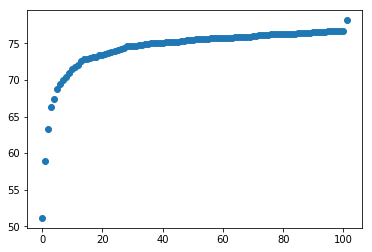

In [12]:
plt.scatter(range(num_periods+2), all_payoffs[:num_periods+2])

In [13]:
Environment = landscape(n,k)    
start_time = time.time()
for i in range(100): Environment.reset() # 90% from cal_lands
print(time.time()-start_time)

23.152421236038208


In [14]:
start_time = time.time()
for i in range(100): Alice.search(Environment.lands, num_periods)
print(time.time()-start_time)

8.827234268188477
